## Imports

In [1]:
%matplotlib inline
# Core
import numpy as np
import cv2
import io
from skimage.measure import label, regionprops
from imageio import imwrite
import statistics as stats
import math
import sys
import PIL

# Visualization
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

# File Chooser
import tkinter as tk
from tkinter import filedialog

ModuleNotFoundError: No module named 'cv2'

In [2]:
# Settings & Globals
printText = False

kernel = np.ones((3, 3), np.uint8)

## Image Processing

In [3]:
# Showing image
def showImage(img, title1 = "Original"):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img), plt.title(title1)
  plt.show()

In [4]:
# Getting image from path
def getImage(file_path=""):
    if file_path == "":
        file_path = filedialog.askopenfilename(filetypes=[("Image Files", ".png .jpg")])
    img = cv2.imread(file_path)
    
    return img

In [5]:
# To greyscale image
def grayscale(img):
    copy = img.copy()
    copy[:, :, 0] = copy[:, :, 2]  = 0
    gray = cv2.cvtColor(copy, cv2.COLOR_BGR2GRAY)
    return gray

In [6]:
#  To truncate image (not needed)
def truncate_image(image,y_front=0,y_back=40,x_front=0,x_back=0,save=False,name=""):
    height,width=image.shape[:2]
    print(image.shape)
    if(len(image.shape)==2):
        image=image[y_front:height-y_back-1,x_front:width-x_back-1]
    else:
        image=image[y_front:height-y_back-1,x_front:width-x_back-1,:]
    if(save):
        if(name==""):
            name="truncated_image.png"
        imwrite(name,image)
    return image

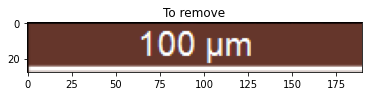

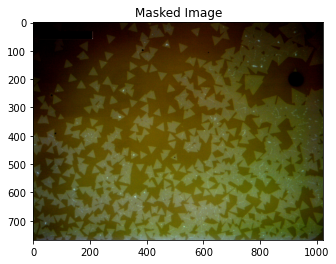

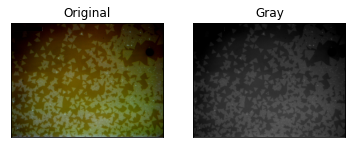

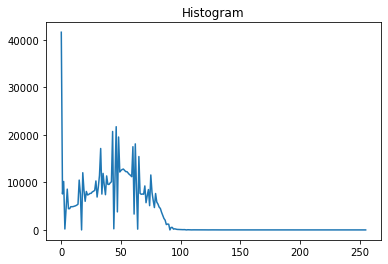

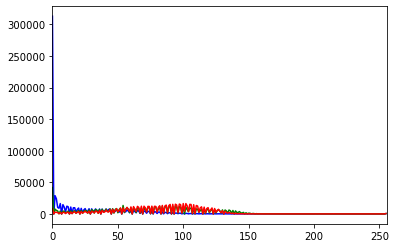

In [7]:
# setting up
img = getImage("img3.png")

# finding area to mask off
showImage(img[32:60,20:210,:], "To remove")

# create mask to remove top left part
mask = np.full(img.shape[:2], 255,np.uint8)
mask[32:60,20:210] = 0
masked_img = cv2.bitwise_and(img,img,mask = mask)
showImage(masked_img, "Masked Image")

gray = grayscale(masked_img)

# showing images
plt.subplot(1,2,1), plt.imshow(cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB))
plt.title("Original"), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2), plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
plt.title("Gray"), plt.xticks([]), plt.yticks([])
plt.show()

# creating histograms of grayscaled image
hist_mask = cv2.calcHist([gray],[0],mask,[256],[0,256])
plt.title("Histogram")
plt.plot(hist_mask);plt.show()

color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()


## Applying Otsu

In [8]:
# Gaussian blurring


In [9]:
# Open and Close morph
def morph(img, openIter = 3, closeIter = 3):
    clean = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=openIter)
    clean = cv2.morphologyEx(clean, cv2.MORPH_CLOSE, kernel, iterations=closeIter)
    return clean

In [10]:
def adaptiveThresholding(img, blockSize=505, C=-2):
    gray = cv2.adaptiveThreshold(
        img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blockSize, C
    )  ########## 2 magic numbers here
    plt.subplot(1,3,1),plt.imshow(img,'gray')
    plt.title('Original Noisy Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(1,3,2),plt.hist(img.ravel(),256)
    plt.title('Histogram'), plt.xticks([]), plt.yticks([])
    plt.subplot(1,3,3),plt.imshow(gray,'gray')
    plt.title("OpenCV Adaptive Thresholding"), plt.xticks([]), plt.yticks([])   
    
    plt.show()
    return gray

(768, 1024)


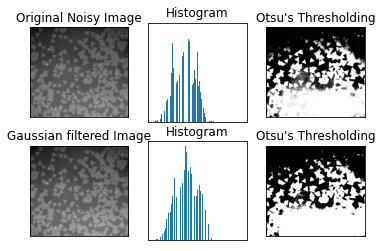

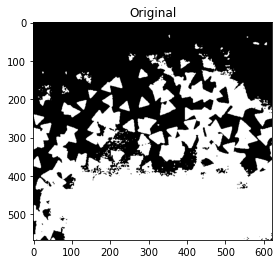

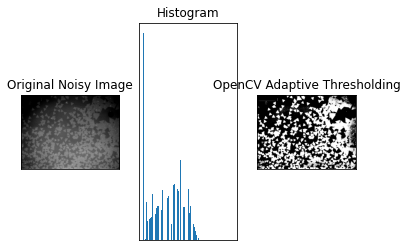

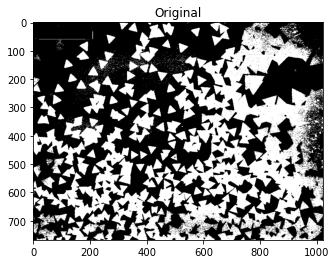

In [15]:
def otsuThresholding(img):
    ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    blur = cv2.GaussianBlur(img,(5,5),0)
    ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    plt.subplot(2,3,1),plt.imshow(img,'gray')
    plt.title('Original Noisy Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(2,3,2),plt.hist(img.ravel(),256)
    plt.title('Histogram'), plt.xticks([]), plt.yticks([])
    plt.subplot(2,3,3),plt.imshow(th2,'gray')
    plt.title("Otsu's Thresholding"), plt.xticks([]), plt.yticks([])   
    
    plt.subplot(2,3,4),plt.imshow(blur,'gray')
    plt.title('Gaussian filtered Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(2,3,5),plt.hist(blur.ravel(),256)
    plt.title('Histogram'), plt.xticks([]), plt.yticks([])
    plt.subplot(2,3,6),plt.imshow(th3,'gray')
    plt.title("Otsu's Thresholding"), plt.xticks([]), plt.yticks([])   

    plt.show()
    return th3
showImage(otsuThresholding(truncate_image(gray,100,100,200,200)))
showImage(adaptiveThresholding(gray, blockSize=505, C=-2))


In [12]:
def truncate_image(image,y_front=0,y_back=40,x_front=0,x_back=0,save=False,name=""):
    height,width=image.shape[:2]
    print(image.shape)
    if(len(image.shape)==2):
        image=image[y_front:height-y_back-1,x_front:width-x_back-1]
    else:
        image=image[y_front:height-y_back-1,x_front:width-x_back-1,:]
    if(save):
        if(name==""):
            name="truncated_image.png"
        imwrite(name,image)
    return image

In [ ]:
def splitImage():
    